### Forest structure using PDAL + Python

Dr Adam Steer, November 2019.

In [1]:
NODATA_VALUE = -9999
LCF_HEIGHTS = [0, 0.05, 0.5, 1, 2, 3]



In [2]:
#imports
import pdal
import numpy as np
import json

import shapely
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import box
#from shapely.strtree import STRtree


import geopandas as gpd
import pandas as pd
import osmnx as ox

import os

import sys

sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../callingelvis'))

# not using this, using geopandas instead
from rtree import index

# this is needed to create a raster from the output array
from osgeo import gdal
import osgeo.osr as osr

In [3]:
from callingelvis import anybodyhome

import forestmetrics.forestmetrics as metrics
import forestmetrics.utils as forestutils

#import forestpipeline


In [4]:
def compute_tern_products(metadata, points, sindex, resolution, lasfile, outpath):
    """
    Wrapper to iterate over the input data and generate rasters for each product.
    
    *note this part could be paralellised - maybe per-product, or per-cell
    
    Each grid square processed in this loop corresponds to one pixel in an output raster.
    
    """
    
    #set up an 'output resolution' sized grid - like a fishnet grid.
    # each polygon in the resulting set covers an area of 'resolution X resolution'
    pixel_grid = forestutils.gen_raster_cells(metadata, resolution)
    
    #set up output rasters
    
    # get tile width and height
    tile_width = metadata["metadata"]["readers.las"]["maxx"] - metadata["metadata"]["readers.las"]["minx"]
    tile_height = metadata["metadata"]["readers.las"]["maxy"] - metadata["metadata"]["readers.las"]["miny"]

    raster_xsize = int(np.ceil(tile_width) / resolution)
    raster_ysize = int(np.ceil(tile_height) / resolution)
    
    #replicate for all products...
    vh_raster = np.zeros((raster_xsize, raster_ysize))
    vcf_raster = np.zeros((raster_xsize, raster_ysize))
    cth_raster = np.zeros((raster_xsize, raster_ysize))
    cbh_raster = np.zeros((raster_xsize, raster_ysize))
    fbf_raster = np.zeros((raster_xsize, raster_ysize))
    cli_raster = np.zeros((raster_xsize, raster_ysize))
    density_raster = np.zeros((raster_xsize, raster_ysize))
    
    veg_below_dict = {}

    veg_below_dict["all"] = np.zeros((raster_xsize, raster_ysize))
    for height in LCF_HEIGHTS:
        veg_below_dict[str(height)] = np.zeros((raster_xsize, raster_ysize))
    
    #internal loop around grid squares covering the LAS tile.
    # this is another ppoint for parallelisation - since we can set up a list of geometries
    # and cast that at multipuple processes, setting up one process per grid square
    # another way to do this would be to recast this loop block into a function which can  
    # be called by one process per product
    # the second strategy seems easier, then only one process is trying to write into each
    # output array.
    
    for pixel in pixel_grid:
        
        #compute output array index for this cell:
        poly_x, poly_y = pixel.centroid.xy
        
        poly_base_x = poly_x[0] - metadata["metadata"]["readers.las"]["minx"]
        poly_base_y = poly_y[0] - metadata["metadata"]["readers.las"]["miny"]
        
        array_x = int(np.floor((poly_base_x / (resolution)) ))
        array_y = int(np.floor((poly_base_y / (resolution)) ))
                
        #get points for this cell
        matches = forestutils.get_cell_points(pixel, points, sindex)
        
        #compute in order
        #VH
        vh_raster[array_x, array_y] = metrics.comp_vh(matches)
        
        #VCF
        vcf_raster[array_x, array_y] = metrics.comp_vcf(matches)
        
        #LCF - long-ish process..
        # compute a dictionary of points below height thresholds
        veg_below = metrics.comp_veg_layers(matches, LCF_HEIGHTS)
        
        # add the first element of the dictionary to a raster output
        veg_below_dict["all"][array_x, array_y] = veg_below["all"]
        
        #iterate over the height thresholds and do likewise...
        for height in LCF_HEIGHTS:
            veg_below_dict[str(height)][array_x, array_y] = veg_below[str(height)]
        
        #CTH
        cth_raster[array_x, array_y] = metrics.comp_cth(matches)
        
        #CBH
        cbh_raster[array_x, array_y] = metrics.comp_cbh(matches)
        
        #FBF
        fbf_raster[array_x, array_y] = metrics.comp_fbf(matches)
        
        #CLI
        cli_raster[array_x, array_y] = metrics.comp_cli(matches)
        
        #density
        density_raster[array_x, array_y] = metrics.comp_density(matches, resolution)


    #end of computing stuff, time to make outputs...
    
    #compute LCF values given our height thresholded veg counts
    lcf = metrics.comp_lcf(veg_below_dict, vcf_raster)
    
    if (not os.path.isdir(outpath + "/dem")):
        os.mkdir(outpath + "/dem")
    
    dem = forestutils.comp_dem(lasfile, outpath, resolution)
    
    tern_products = {}
    tern_products["vh"] = vh_raster
    tern_products["vcf"] = vcf_raster
    tern_products["cth"] = cth_raster
    tern_products["cbh"] = cbh_raster
    tern_products["fbf"] = fbf_raster
    tern_products["cli"] = cli_raster
    tern_products["lcf_h"] = lcf["lcf_h"]
    tern_products["lcf_os"] = lcf["lcf_os"]
    tern_products["lcf_us"] = lcf["lcf_us"]
    tern_products["lcf_cf"] = lcf["lcf_cf"]
    tern_products["lcf_ef"] = lcf["lcf_ef"]
    tern_products["lcf_nsf"] = lcf["lcf_nsf"]
    tern_products["density"] = density_raster

    return(tern_products)

In [5]:
def export_tern_products(tern_products, metadata, resolution, lasfile, outpath):
    
    #set up GDAL parameters
    
    wktcrs = metadata["metadata"]["readers.las"]["comp_spatialreference"]
    
    raster_parameters = {}
    raster_parameters["width"] = np.shape(tern_products["vh"])[0]
    raster_parameters["height"] = np.shape(tern_products["vh"])[1]
    raster_parameters["upperleft_x"] = metadata["metadata"]["readers.las"]["minx"]
    raster_parameters["upperleft_y"] = metadata["metadata"]["readers.las"]["maxy"]
    raster_parameters["resolution"] = resolution
    raster_parameters["projection"] = wktcrs
    
    fileroot = forestutils.make_file_rootname(lasfile)
    print(fileroot)
    
    for productname in tern_products.keys():
    
        if (not os.path.isdir(os.path.join(outpath,
                                       productname))):
            os.mkdir(os.path.join(outpath,
                                  productname))
    
    
        #set output filenames
        separator = "-"
        
        raster_name = separator.join([fileroot,
                                     productname,
                                     str(resolution) + "m.tiff"])
        raster_path = os.path.join(outpath,
                                   productname,
                                   raster_name)
        print(raster_path)
        forestutils.write_product_geotiff(tern_products[productname], raster_path, raster_parameters)


    return()

## Testing functionality using a local file
The following section generates metrics from a local LAZ file. Plugging in download mechanics from ELVIS will be added later

In [6]:
#lidar test file - Mt Ainslie, chosen for varied vegetation cover and topography
# this is pretty big, try it out if you've got more resources than my macbook pro!

# thinking ahead, there will probably end up being a file splitting pre-process for 
# tiles like these... capping at say, 20 mill points. Sorting data before splitting
# will be essential.

#lasfile = "/Volumes/Antares/ACT-lidar/8ppm/callingelvis-testdata/ACT2015_8ppm-C3-AHD_6966094_55.laz"

In [7]:
#lasfile = "/Volumes/Antares/fire-test/NSW Government - Spatial Services-2/Point Clouds/AHD/StAlbans201709-LID2-C3-AHD_2866308_56_0002_0002/StAlbans201709-LID2-C3-AHD_2866308_56_0002_0002.las"

In [8]:
lasfile = "../../callingelvis-sampledata/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002.las"

In [9]:
#lasfile = "../../callingelvis-sampledata/uncompahgre.laz"

In [10]:
# dump everything from memory
points = None
df = None
tern_products = None

In [11]:
%%time

metadata = forestutils.readlasmetadata(lasfile)

CPU times: user 72.1 ms, sys: 7.7 ms, total: 79.8 ms
Wall time: 79.2 ms


In [12]:
%%time
# this part of the process is simply reading from the source file into a Numpy 
# array. No analysis yet.

points = forestutils.readlasfile(lasfile)

CPU times: user 9.66 s, sys: 256 ms, total: 9.92 s
Wall time: 9.88 s


In [13]:
# uncomment to examine LAS metadata
#metadata

In [14]:
#points = [ points[0]["X"], points[0]["Y"], points[0]["Z"]]

#,"Y","Z","ReturnNumber","NumberofReturns","HeightAboveGround"]

In [15]:
points

[array([(658000.05, 5974000.27, 1076.508,  4, 1, 2, 1, 0,  5, -19., 0, 13, 2.02784444e+08, 10.8 ),
        (658000.2 , 5974000.79, 1066.058, 13, 1, 1, 0, 0, 12, -22., 1, 13, 2.02784444e+08, -0.41),
        (658000.61, 5974000.71, 1066.068, 14, 1, 1, 0, 0, 12, -22., 1, 13, 2.02784444e+08,  0.36),
        ...,
        (659999.  , 5975998.23,  952.922, 19, 1, 1, 1, 0, 12, -19., 0, 14, 2.02785090e+08, -0.06),
        (659998.59, 5975999.58,  952.672, 26, 1, 1, 0, 0,  2,  14., 0, 12, 2.02783264e+08,  0.  ),
        (659999.52, 5975999.01,  952.852, 17, 1, 1, 0, 0, 12, -19., 0, 14, 2.02785090e+08,  0.08)],
       dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('HeightAboveGround', '<f8')])]

In [16]:
%%time

#here we read points into a GeoDataFrame and dump the labelled array.
# this is a pretty expensive step RAM wise, we're duplicating all the points...
# df = gpd.GeoDataFrame(points)
# ...and we're adding a geometry column... probably slows thinsg down a bit...

df = forestutils.pdal2df(points)

# set the points structured array to None, it isn't used anymore
#points = None

CPU times: user 18.5 s, sys: 424 ms, total: 18.9 s
Wall time: 19 s


In [17]:
df

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,HeightAboveGround,geometry
0,658000.05,5974000.27,1076.508,4,1,2,1,0,5,-19.0,0,13,2.027844e+08,10.80,POINT (658000.050 5974000.270)
1,658000.20,5974000.79,1066.058,13,1,1,0,0,12,-22.0,1,13,2.027844e+08,-0.41,POINT (658000.200 5974000.790)
2,658000.61,5974000.71,1066.068,14,1,1,0,0,12,-22.0,1,13,2.027844e+08,0.36,POINT (658000.610 5974000.710)
3,658000.50,5974000.91,1066.108,12,1,1,1,0,12,-22.0,1,13,2.027844e+08,0.40,POINT (658000.500 5974000.910)
4,658000.92,5974000.82,1066.078,13,1,1,1,0,12,-22.0,1,13,2.027844e+08,0.37,POINT (658000.920 5974000.820)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248902,659998.26,5975998.72,952.822,19,1,1,0,0,12,-19.0,0,14,2.027851e+08,0.05,POINT (659998.260 5975998.720)
2248903,659998.51,5975998.82,952.772,24,1,1,1,0,2,12.0,1,12,2.027833e+08,0.00,POINT (659998.510 5975998.820)
2248904,659999.00,5975998.23,952.922,19,1,1,1,0,12,-19.0,0,14,2.027851e+08,-0.06,POINT (659999.000 5975998.230)
2248905,659998.59,5975999.58,952.672,26,1,1,0,0,2,14.0,0,12,2.027833e+08,0.00,POINT (659998.590 5975999.580)


In [18]:
%%time

# here we generate an RTree index on the dataframe using GeoPandas.
# also pretty expensive... 

sindex = forestutils.spatialindex(df)

CPU times: user 1min 42s, sys: 848 ms, total: 1min 43s
Wall time: 1min 43s


In [19]:
# set an output resolution

resolution = 25

In [20]:
metadata["metadata"]["readers.las"]["minx"]

658000

In [21]:
points[0]["X"][1:10]

array([658000.2 , 658000.61, 658000.5 , 658000.92, 658000.06, 658000.22,
       658000.13, 658000.45, 658000.48])

In [22]:
#points2 = [points[0]["X"],points[0]["Y"],points[0]["Z"],points[0]["ReturnNumber"],points[0]["NumberOfReturns"]]

In [23]:
%%time 
#df2 = gpd.GeoDataFrame(points2)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [ ]:
df2 = None

In [ ]:
points2 = None 

In [ ]:
points = None

In [24]:
%%time

#produce some rasters!

tern_products = compute_tern_products(metadata, df, sindex, resolution, lasfile, "../..")

/Users/adam/anaconda3/envs/callingelvis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/adam/anaconda3/envs/callingelvis/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/adam/Spatialised/ANU-WALD/forestmetrics/forestmetrics/forestmetrics.py:173: RuntimeWarning: invalid value encountered in true_divide
  veg_below["all"])
/Users/adam/Spatialised/ANU-WALD/forestmetrics/forestmetrics/forestmetrics.py:176: RuntimeWarning: invalid value encountered in true_divide
  veg_below["2"])
/Users/adam/Spatialised/ANU-WALD/forestmetrics/forestmetrics/forestmetrics.py:179: RuntimeWarning: invalid value encountered in true_divide
  veg_below["0.5"])
/Users/adam/Spatialised/ANU-WALD/forestmetrics/forestmetrics/forestmetrics.py:183: RuntimeWarning: invalid value encountered in true_divide
  veg_below["1"])
/Users/adam/S

CPU times: user 46.2 s, sys: 129 ms, total: 46.4 s
Wall time: 46.4 s


In [25]:
#write some rasters

export_tern_products(tern_products, metadata, resolution, lasfile, "../../")

Berridale201802-LID2-C3-AHD_6585974_55_0002_0002
../../vh/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-vh-25m.tiff
../../vcf/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-vcf-25m.tiff
../../cth/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-cth-25m.tiff
../../cbh/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-cbh-25m.tiff
../../fbf/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-fbf-25m.tiff
../../cli/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-cli-25m.tiff
../../lcf_h/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-lcf_h-25m.tiff
../../lcf_os/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-lcf_os-25m.tiff
../../lcf_us/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-lcf_us-25m.tiff
../../lcf_cf/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-lcf_cf-25m.tiff
../../lcf_ef/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-lcf_ef-25m.tiff
../../lcf_nsf/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-lcf_nsf-25m.tiff
../../density/Berridale201802-LID2-C3-AHD_6585974_55_

()

In [26]:
resolution = 5

In [44]:
%%time

#produce some rasters!

tern_products = compute_tern_products(metadata, df, sindex, resolution, lasfile, "../..")

no first returns, set vcf to -9999


ValueError: arange: cannot compute length

In [28]:
export_tern_products(tern_products, metadata, resolution, lasfile, "../../")

Berridale201802-LID2-C3-AHD_6585974_55_0002_0002
../../vh/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-vh-5m.tiff
../../vcf/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-vcf-5m.tiff
../../cth/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-cth-5m.tiff
../../cbh/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-cbh-5m.tiff
../../fbf/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-fbf-5m.tiff
../../cli/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-cli-5m.tiff
../../lcf_h/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-lcf_h-5m.tiff
../../lcf_os/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-lcf_os-5m.tiff
../../lcf_us/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-lcf_us-5m.tiff
../../lcf_cf/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-lcf_cf-5m.tiff
../../lcf_ef/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-lcf_ef-5m.tiff
../../lcf_nsf/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-lcf_nsf-5m.tiff
../../density/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002-de

()

In [30]:
from matplotlib import pyplot as plt

%matplotlib inline

In [31]:
tern_products.keys()

dict_keys(['vh', 'vcf', 'cth', 'cbh', 'fbf', 'cli', 'lcf_h', 'lcf_os', 'lcf_us', 'lcf_cf', 'lcf_ef', 'lcf_nsf', 'density'])

Text(0.5, 1.0, 'Vegetation cover fraction (VCF)')

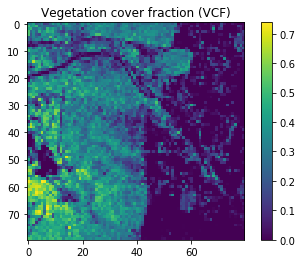

In [32]:
plt.imshow(np.rot90(tern_products["vcf"]))
plt.colorbar()
plt.title("Vegetation cover fraction (VCF)")

Text(0.5, 1.0, 'Canopy top height (CTH)')

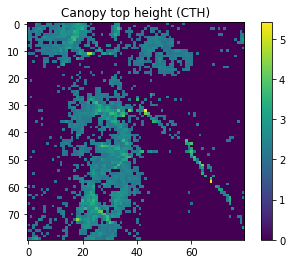

In [33]:
plt.imshow(np.rot90(tern_products["cth"]), vmin = 0)
plt.colorbar()
plt.title("Canopy top height (CTH)")


Text(0.5, 1.0, 'Canopy base height (CBH)')

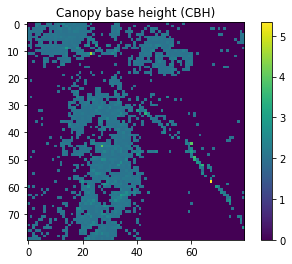

In [34]:
plt.imshow(np.rot90(tern_products["cbh"]), vmin = 0)
plt.colorbar()
plt.title("Canopy base height (CBH)")

Text(0.5, 1.0, 'Canopy top and base height difference')

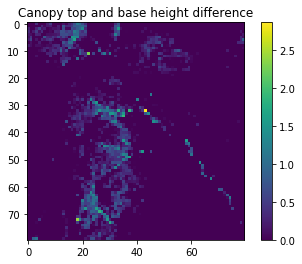

In [35]:
plt.imshow(np.rot90(tern_products["cth"] -tern_products["cbh"]))
plt.colorbar()
plt.title("Canopy top and base height difference")

Text(0.5, 1.0, 'Building fraction (FBF)')

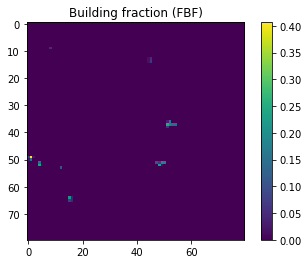

In [36]:
plt.imshow(np.rot90(tern_products["fbf"]))
plt.colorbar()
plt.title("Building fraction (FBF)")

Text(0.5, 1.0, 'Canopy Layering Index (CLI)')

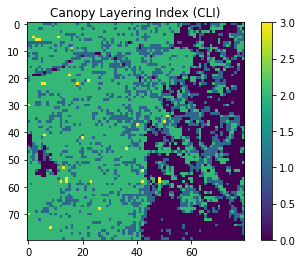

In [37]:
plt.imshow(np.rot90(tern_products["cli"]))
plt.colorbar()
plt.title("Canopy Layering Index (CLI)")

Text(0.5, 1.0, 'LCF_H')

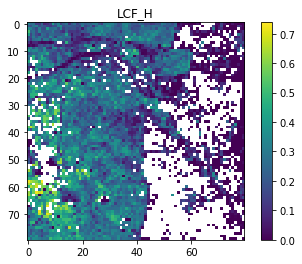

In [38]:
plt.imshow(np.rot90(tern_products["lcf_h"]))
plt.colorbar()
plt.title("LCF_H")

Text(0.5, 1.0, 'LCF_OS')

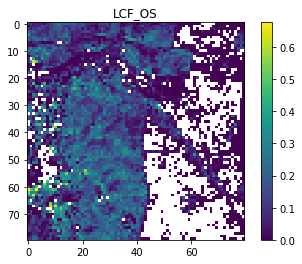

In [39]:
plt.imshow(np.rot90(tern_products["lcf_os"]))
plt.colorbar()
plt.title("LCF_OS")

Text(0.5, 1.0, 'LCF_US')

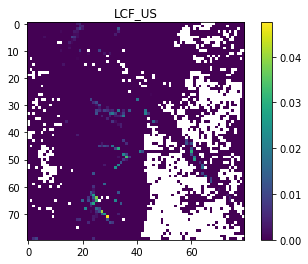

In [40]:
plt.imshow(np.rot90(tern_products["lcf_us"]))
plt.colorbar()
plt.title("LCF_US")

Text(0.5, 1.0, 'LCF_CF')

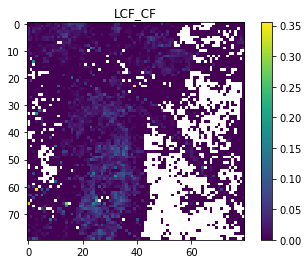

In [41]:
plt.imshow(np.rot90(tern_products["lcf_cf"]))
plt.colorbar()
plt.title("LCF_CF")

Text(0.5, 1.0, 'density')

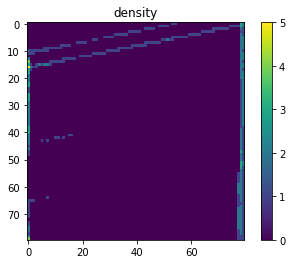

In [42]:
plt.imshow(np.rot90(tern_products["density"]))
plt.colorbar()
plt.title("density")

In [43]:
polygons = forestutils.gen_raster_cells(metadata, resolution)

In [ ]:
polygons[40]

In [ ]:
matches = forestutils.get_cell_points(polygons[55], df, sindex)

In [ ]:
metrics.comp_cli(matches)

In [ ]:
metrics.comp_density(matches, resolution)

## code purgatory

In [ ]:
%%time
# an attempt at building an index without pandas. Pandas was far easier...

## rtree index building straight from the point dataset... which also duplicates the point set...
# I think this is a pretty slow way... if we're looping over points might as well process them
# at the same time...
idx = index.Index()
for pid, point in enumerate(points[0]):
    idx.insert(pid, (point[0], point[1], point[0], point[1]), point)


In [ ]:
## for raster writing later...

### set up GDAL parameters
    
    wktcrs = metadata["metadata"]["readers.las"]["comp_spatialreference"]
    
    raster_parameters = {}
    raster_parameters["width"] = np.shape(vcf_raster)[0]
    raster_parameters["height"] = np.shape(vcf_raster)[1]
    raster_parameters["upperleft_x"] = metadata["metadata"]["readers.las"]["minx"]
    raster_parameters["upperleft_y"] = metadata["metadata"]["readers.las"]["maxy"]
    raster_parameters["resolution"] = resolution
    raster_parameters["projection"] = wktcrs
    
    fileroot = forestutils.make_file_rootname(lasfile)
    print(fileroot)
    
    if (not os.path.isdir(outpath + "/vcf")):
        os.mkdir(outpath + "/vcf")
    if (not os.path.isdir(outpath + "/cth")):
        os.mkdir(outpath + "/cth")
    if (not os.path.isdir(outpath + "/cbh")):
        os.mkdir(outpath + "/cbh")
    if (not os.path.isdir(outpath + "/fbf")):
        os.mkdir(outpath + "/fbf")
    if (not os.path.isdir(outpath + "/cli")):
        os.mkdir(outpath + "/cli")
        
    #lcf will hold 3 output rasters
    if (not os.path.isdir(outpath + "/lcf")):
        os.mkdir(outpath + "/lcf")


    
    #set output filenames
    vcf_raster_path = os.path.join(outpath,
                                   "vcf",
                                   fileroot + "-VCF-" + str(resolution) + "m.tiff")
    
    print(vcf_raster_path)
    cth_raster_path = outpath + "/cth/" + fileroot + "-CTH-" + str(resolution) + "m.tiff"
    cbh_raster_path = outpath + "/cbh/" + fileroot + "-CBH-" + str(resolution) + "m.tiff"
    fbf_raster_path = outpath + "/fbf/" + fileroot + "-FBF-" + str(resolution) + "m.tiff"
    cli_raster_path = outpath + "/cli/" + fileroot + "-CLI-" + str(resolution) + "m.tiff"


    #write geotiffs and return arrays for inspection...
    
    #TO DO:
    # - density
    # - lcf products

    forestutils.write_product_geotiff(vcf_raster, vcf_raster_path, raster_parameters)
    forestutils.write_product_geotiff(cth_raster, cth_raster_path, raster_parameters)
    forestutils.write_product_geotiff(cbh_raster, cbh_raster_path, raster_parameters)
    forestutils.write_product_geotiff(fbf_raster, fbf_raster_path, raster_parameters)
    forestutils.write_product_geotiff(cli_raster, cli_raster_path, raster_parameters)
    